In [1]:
# Set the working directory to a specific path
setwd("~/SSMuLA")

In [2]:
library(tidyverse)
library(Biostrings)
library(lme4)
library(Matrix)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownam

In [3]:
# install.packages("lme4", type = "source")

In [4]:
## read in the count data
readRDS("data/folA/sequence_reads_counts.RDS") -> count_data

str(count_data)

List of 2
 $ before: int [1:6, 1:261378] 35613 27972 30530 25930 28702 22740 1796 1352 1398 1206 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:6] "Sample_F01" "Sample_F02" "Sample_F03" "Sample_F04" ...
  .. ..$ : chr [1:261378] "GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC" "GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTACCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC" "GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGAAAATTAAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC" "GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTAAAATTTGAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC" ...
 $ M9+TMP: int [1:6, 1:261333] 42405 39138 46575 35291 52112 28608 40852 39453 46503 34711 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:6] "Sample_F01" "Sample_F02" "Sample_F03" "Sample_F04" ...
  .. ..$ : chr [1:261333] "GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGA

In [5]:
class(count_data$before)
dim(count_data$before)
class(count_data$"M9+TMP")
dim(count_data$"M9+TMP")

write.csv(count_data$before, file = "data/folA/before.csv")
write.csv(count_data$"M9+TMP", file = "data/folA/after.csv")

[1] "matrix" "array"

[1]      6 261378

[1] "matrix" "array"

[1]      6 261333

In [6]:
gcode = 
        data.frame(codon1=names(GENETIC_CODE),
                   aa1=GENETIC_CODE) %>% 
            full_join(.,
                     data.frame(codon2=names(GENETIC_CODE),
                                aa2=GENETIC_CODE),
                     by = character()) %>% 
            full_join(.,
                     data.frame(codon3=names(GENETIC_CODE),
                                aa3=GENETIC_CODE),
                     by = character()) %>% 
            mutate(SV=paste(codon1,codon2,codon3,sep="")) 
 head(gcode)           


Warning message:
“Using `by = character()` to perform a cross join was deprecated in dplyr 1.1.0.
ℹ Please use `cross_join()` instead.”


,codon1,aa1,codon2,aa2,codon3,aa3,SV
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,TTT,F,TTT,F,TTT,F,TTTTTTTTT
2,TTT,F,TTT,F,TTC,F,TTTTTTTTC
3,TTT,F,TTT,F,TTA,L,TTTTTTTTA
4,TTT,F,TTT,F,TTG,L,TTTTTTTTG
5,TTT,F,TTT,F,TCT,S,TTTTTTTCT
6,TTT,F,TTT,F,TCC,S,TTTTTTTCC


In [7]:


sv_gcode =  data.frame(SV=substr(colnames(count_data$before),76-24,84-24),
                       SVseq=colnames(count_data$before)) %>% 
            left_join(.,gcode,by="SV")

head(sv_gcode)



,SV,SVseq,codon1,aa1,codon2,aa2,codon3,aa3
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,GCCGATCTC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCC,A,GAT,D,CTC,L
2,ACCGATCTC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTACCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,ACC,T,GAT,D,CTC,L
3,GAAAATTAA,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGAAAATTAAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GAA,E,AAT,N,TAA,*
4,AAAATTTGA,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTAAAATTTGAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,AAA,K,ATT,I,TGA,*
5,AAAAAATGA,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTAAAAAATGAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,AAA,K,AAA,K,TGA,*
6,AAATAAAAT,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTAAATAAAATGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,AAA,K,TAA,*,AAT,N


In [8]:
counts_before = count_data$before %>% 
                reshape2::melt(.) %>% 
                dplyr::rename(Sample=Var1,
                       SVseq=Var2,
                       Nreads=value) %>%
                left_join (.,sv_gcode,by="SVseq") %>%
                left_join(.,
                        data.frame( Sample=rownames(count_data$before),
                                    Total_Nreads=c(apply(count_data$before,1,sum)),
                                    row.names=NULL),
                         by="Sample") 

head(counts_before)

,Sample,SVseq,Nreads,SV,codon1,aa1,codon2,aa2,codon3,aa3,Total_Nreads
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,Sample_F01,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,35613,GCCGATCTC,GCC,A,GAT,D,CTC,L,69576517
2,Sample_F02,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,27972,GCCGATCTC,GCC,A,GAT,D,CTC,L,57285073
3,Sample_F03,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,30530,GCCGATCTC,GCC,A,GAT,D,CTC,L,60143775
4,Sample_F04,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,25930,GCCGATCTC,GCC,A,GAT,D,CTC,L,53122388
5,Sample_F05,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,28702,GCCGATCTC,GCC,A,GAT,D,CTC,L,59065357
6,Sample_F06,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,22740,GCCGATCTC,GCC,A,GAT,D,CTC,L,45877874


In [9]:
count_data$before %>% head()

,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTACCGATCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGAAAATTAAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTAAAATTTGAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTAAAAAATGAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTAAATAAAATGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTATAAATTGAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTTGTAAATAAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTTATAAAATAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTTTTAAAATTGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,⋯,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTTGCGGCAGGGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTTGTGCCACGGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTCGCCGCCACGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTACCGCTCCGGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTCGGCGTTTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTCGCGGCAGTGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTACCGCCTCGGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGTCGGTCTCGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTCAACCCACGGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC,GCGGTAGATCGCGTTATCGGCATGGAAAACGCCATGCCGTGGAACCTGCCTGCCGATCTAGCCTGGTTTAAACGCAACACCTTAAATAAACCCGTGATTATGGGCCGCCATACC
Sample_F01,35613,1796,1491,1473,1382,1471,1397,1263,1389,1479,⋯,18,26,10,23,15,16,21,23,20,22
Sample_F02,27972,1352,1404,1158,1267,1148,983,1154,1030,1031,⋯,15,20,10,24,10,34,17,10,25,15
Sample_F03,30530,1398,1284,1317,1102,1246,1332,1173,1095,1157,⋯,11,12,22,7,19,4,4,23,14,19
Sample_F04,25930,1206,1124,1158,1039,1037,1044,984,1009,992,⋯,26,11,21,12,13,12,20,11,16,17
Sample_F05,28702,1284,1255,1288,1248,1045,1185,1216,1153,1081,⋯,12,26,23,29,26,13,34,20,16,14
Sample_F06,22740,1114,859,894,1026,929,852,956,984,902,⋯,18,5,14,5,17,21,4,13,9,13


In [10]:
data = data.frame( Nreads = c(430,455,465,818,998,812),
            Total = c(1000,1000,1000,1000,1000,1000),
            time = c(0,0,0,35,35,35)) 

glm1 =glm( cbind(Nreads,Total-Nreads) ~ time, data=data, family=binomial)

In [11]:
data = data.frame( Nreads = c(430,455,465,818,998,812),
            Total = c(1000,1000,1000,1000,1000,1000),
            time = c(0,0,0,35,35,35)) 

glm2 =glm( (Nreads/Total) ~ time, data=data, family=binomial,weights=Total)

In [12]:
coef(glm1)
coef(glm2)

(Intercept)        time 
-0.20067070  0.06159301

(Intercept)        time 
-0.20067070  0.06159301

`geom_smooth()` using formula = 'y ~ x'
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


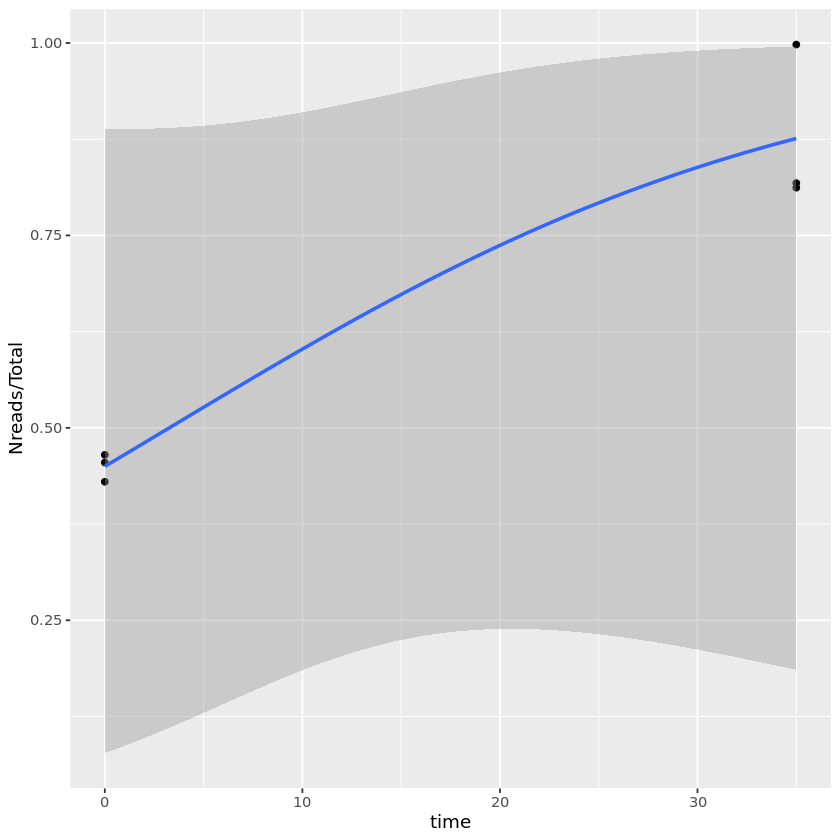

In [13]:
ggplot(data, aes(x=time, y=Nreads/Total)) + 
    geom_point() + 
    geom_smooth(method="glm", method.args=list(family="binomial"))

`geom_smooth()` using formula = 'y ~ x'


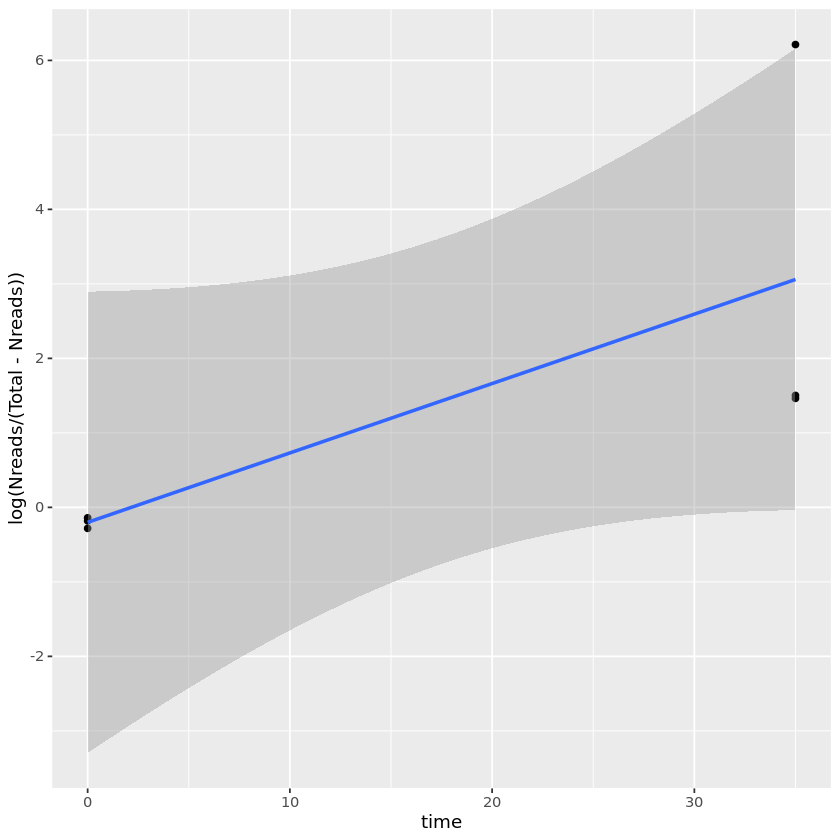

In [14]:
ggplot(data, aes(x=time, y=log(Nreads/(Total-Nreads)))) + 
    geom_point() +
    geom_smooth(method="lm")

In [15]:
data2 = data.frame( Nreads = c(500,455,465,370,350,320,998,818,812),
            Total = c(1000,1000,1000,500,500,500,1000,1000,1000),
            time = c(0,0,0,10,10,10,20,20,20),
            Rep = paste(c(1,2,3,1,2,3,1,2,3))) 

data2

Nreads,Total,time,Rep
<dbl>,<dbl>,<dbl>,<chr>
500,1000,0,1
455,1000,0,2
465,1000,0,3
370,500,10,1
350,500,10,2
320,500,10,3
998,1000,20,1
818,1000,20,2
812,1000,20,3


`geom_smooth()` using formula = 'y ~ x'
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


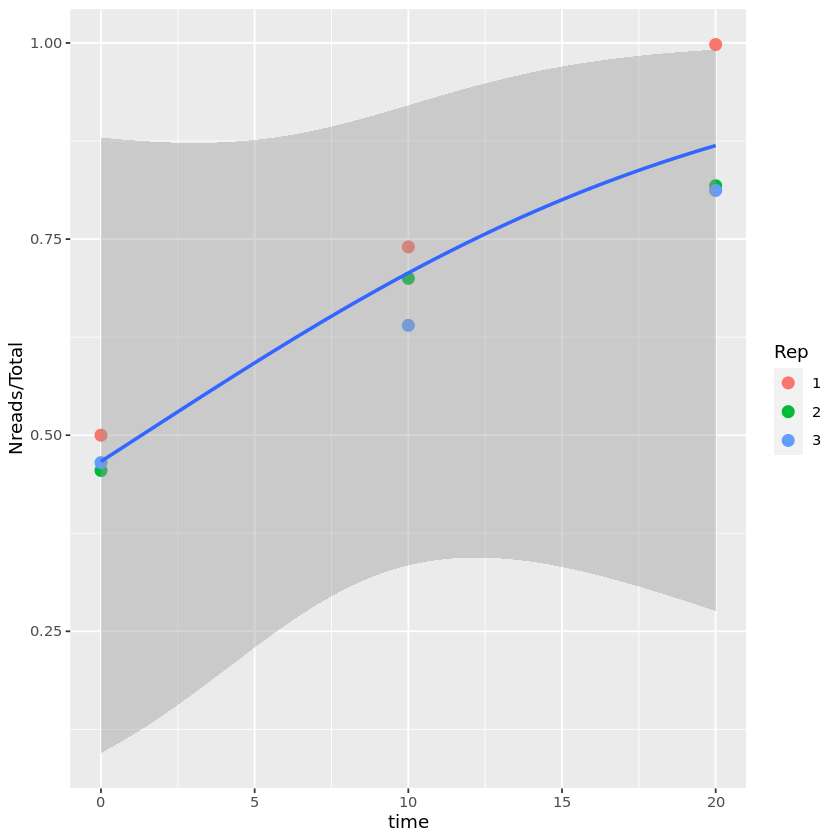

In [16]:
ggplot(data2, aes(x=time, y=Nreads/Total)) + 
    geom_point(aes(color=Rep),size=3) + 
    geom_smooth(method="glm", method.args=list(family="binomial"))

In [17]:

glm2=glm( cbind(Nreads,Total-Nreads) ~ time, data=data2, family=binomial)

summary(glm2)


Call:
glm(formula = cbind(Nreads, Total - Nreads) ~ time, family = binomial, 
    data = data2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.3408  -3.3896  -0.5026   1.4831  15.9141  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.123723   0.035139  -3.521  0.00043 ***
time         0.102024   0.003226  31.621  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1493.54  on 8  degrees of freedom
Residual deviance:  323.74  on 7  degrees of freedom
AIC: 385.61

Number of Fisher Scoring iterations: 5


In [18]:
glmer2=glmer(cbind(Nreads,Total-Nreads) ~ time + (1|Rep), data=data2, family=binomial)

summary(glmer2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: cbind(Nreads, Total - Nreads) ~ time + (1 | Rep)
   Data: data2

     AIC      BIC   logLik deviance df.resid 
   302.8    303.4   -148.4    296.8        6 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.914 -3.324 -1.309  1.632  9.717 

Random effects:
 Groups Name        Variance Std.Dev.
 Rep    (Intercept) 0.07167  0.2677  
Number of obs: 9, groups:  Rep, 3

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.124390   0.158576  -0.784    0.433    
time         0.103402   0.003257  31.746   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
     (Intr)
time -0.144

In [22]:
coef(glmer2)

$Rep
  (Intercept)      time
1   0.2468881 0.1034025
2  -0.2840706 0.1034025
3  -0.3367629 0.1034025

attr(,"class")
[1] "coef.mer"

In [20]:
cbind(data2,prediction = predict(glmer2)) %>%
mutate( prediction2 = binomial()$linkinv(prediction)) -> data_to_plot

`geom_smooth()` using formula = 'y ~ x'
Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


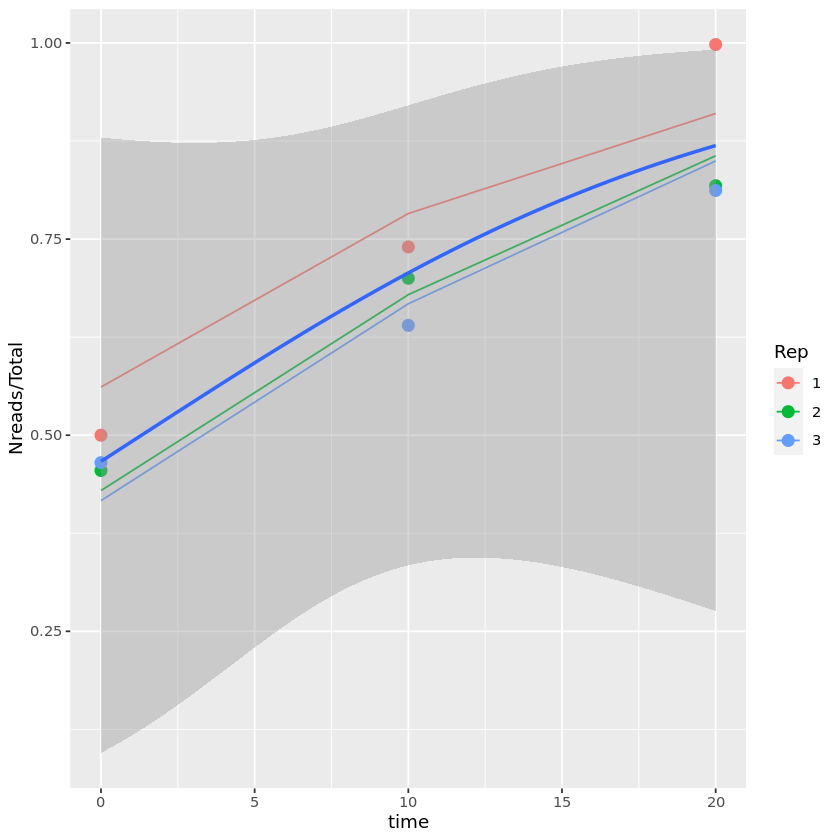

In [21]:
ggplot(data_to_plot, aes(x=time, y=Nreads/Total)) + 
    geom_point(aes(color=Rep),size=3) + 
    geom_line(aes(x=time,y=prediction2,group=Rep,color=Rep))+
    geom_smooth(method="glm", method.args=list(family="binomial"))

In [23]:
## two genotypes

In [24]:
rbind(

data.frame( Nreads = c(430,455,465,818,998,812),
            Total = rep(10000,6),
                       time = c(0,0,0,35,35,35),
                       genotype="A") ,

data.frame( Nreads = c(330,355,365,618,698,612),
            Total = rep(10000,6),
                       time = c(0,0,0,35,35,35),
                       genotype="B") 
) -> data3

data3

Nreads,Total,time,genotype
<dbl>,<dbl>,<dbl>,<chr>
430,10000,0,A
455,10000,0,A
465,10000,0,A
818,10000,35,A
998,10000,35,A
812,10000,35,A
330,10000,0,B
355,10000,0,B
365,10000,0,B


In [25]:
?model.matrix.default

model.matrix               package:stats               R Documentation

_C_o_n_s_t_r_u_c_t _D_e_s_i_g_n _M_a_t_r_i_c_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     ‘model.matrix’ creates a design (or model) matrix, e.g., by
     expanding factors to a set of dummy variables (depending on the
     contrasts) and expanding interactions similarly.

_U_s_a_g_e:

     model.matrix(object, ...)
     
     ## Default S3 method:
     model.matrix(object, data = environment(object),
                  contrasts.arg = NULL, xlev = NULL, ...)
     
_A_r_g_u_m_e_n_t_s:

  object: an object of an appropriate class.  For the default method, a
          model formula or a ‘terms’ object.

    data: a data frame created with ‘model.frame’.  If another sort of
          object, ‘model.frame’ is called first.

contrasts.arg: a list, whose entries are values (numeric matrices,
          ‘function’s or character strings naming functions) to be used
          as replaceme

In [26]:
### time*genotype = time + genotype + time:genotype

In [27]:
 model.matrix(~ genotype*time, data3)

,(Intercept),genotypeB,time,genotypeB:time
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,35,0
5,1,0,35,0
6,1,0,35,0
7,1,1,0,0
8,1,1,0,0
9,1,1,0,0
10,1,1,35,35


In [28]:
glm3 = glm( cbind(Nreads,Total-Nreads) ~ time*genotype, data=data3, family=binomial)

In [29]:
summary(glm3 )

# Coefficients:
#                  Estimate     
# (Intercept)    -3.0550489   logit of A at time 0
# time            0.0203358  slope for A
# genotypeB      -0.2617312  difference of logit of A and B at time 0 A-B
# time:genotypeB -0.0020932  slope difference of A and B


Call:
glm(formula = cbind(Nreads, Total - Nreads) ~ time * genotype, 
    family = binomial, data = data3)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2895  -1.1389  -0.3655   0.7425   4.2298  

Coefficients:
                 Estimate Std. Error  z value Pr(>|z|)    
(Intercept)    -3.0550489  0.0278504 -109.695  < 2e-16 ***
time            0.0203358  0.0009867   20.609  < 2e-16 ***
genotypeB      -0.2617312  0.0419829   -6.234 4.54e-10 ***
time:genotypeB -0.0020932  0.0014939   -1.401    0.161    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 914.94  on 11  degrees of freedom
Residual deviance:  38.46  on  8  degrees of freedom
AIC: 143.4

Number of Fisher Scoring iterations: 3


In [30]:
confint(glm3)


Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-3.110091614,-3.0009114103
time,0.018407850,0.0222760706
genotypeB,-0.344157063,-0.1795661145
time:genotypeB,-0.005019788,0.0008365971


In [31]:
exp(-0.005019788)

[1] 0.9949928

In [32]:
data3 %>% filter(genotype=="A") %>%

glm( cbind(Nreads,Total-Nreads) ~ time, data=., family=binomial) %>%
{coef(.)[2]} -> coefA

data3 %>% filter(genotype=="B") %>%

glm( cbind(Nreads,Total-Nreads) ~ time, data=., family=binomial) %>%
{coef(.)[2]} -> coefB

coefA; coefB 
coefB - coefA

coef(glm3)['time:genotypeB']

time 
0.02033575

time 
0.01824259

time 
-0.002093165

time:genotypeB 
  -0.002093165

In [121]:
sessionInfo()


R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /home/apapkou/miniconda3/envs/lsp/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_GB.utf8       LC_NUMERIC=C             
 [3] LC_TIME=en_GB.utf8        LC_COLLATE=en_GB.utf8    
 [5] LC_MONETARY=en_GB.utf8    LC_MESSAGES=en_GB.utf8   
 [7] LC_PAPER=en_GB.utf8       LC_NAME=C                
 [9] LC_ADDRESS=C              LC_TELEPHONE=C           
[11] LC_MEASUREMENT=en_GB.utf8 LC_IDENTIFICATION=C      

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lme4_1.1-30         Matrix_1.4-1        Biostrings_2.62.0  
 [4] GenomeInfoDb_1.30.1 XVector_0.34.0      IRanges_2.28.0     
 [7] S4Vectors_0.32.4    BiocGenerics_0.40.0 forcats_0.5.1      
[10] stringr_1.4.0       dplyr_1.0.9         purrr_0.3.4        
[13] readr_2.1.2         tidyr_1.2.0        